# 4H - MSG
## Import libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
import gpflow
from gpflow.utilities import print_summary
from sklearn.preprocessing import StandardScaler


## Read in data

In [26]:
# Read data
train = pd.read_csv('../processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train['half_hour'] = train['tpep_pickup_datetime'].dt.hour + train['tpep_pickup_datetime'].dt.minute / 60
train['half_hour'] = train['half_hour'].round(1)
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,half_hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,,
2022-01-24 00:00:00,1395.0,2119.58,181615,10845.93,16718.85,1.96,1134,0,2022-01-24 00:00:00,False,0,0,0.0,1
2022-01-24 12:00:00,2234.0,4223.13,269775,18541.88,28725.63,2.16,1676,0,2022-01-24 12:00:00,False,0,12,12.0,2
2022-01-25 00:00:00,1541.0,2519.35,203483,12578.37,19205.72,2.00,1234,0,2022-01-25 00:00:00,False,1,0,0.0,3
2022-01-25 12:00:00,1845.0,3335.29,224687,15507.65,24210.65,2.16,1419,0,2022-01-25 12:00:00,False,1,12,12.0,4
2022-01-26 00:00:00,1536.0,2246.81,204445,11883.31,18429.15,2.00,1222,0,2022-01-26 00:00:00,False,2,0,0.0,5


In [27]:
# Read data
test = pd.read_csv('../processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test['half_hour'] = test['tpep_pickup_datetime'].dt.hour + test['tpep_pickup_datetime'].dt.minute / 60
test['half_hour'] = test['half_hour'].round(1)
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,half_hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,,
2024-01-22 00:00:00,1418.0,2174.20,198232,16627.86,24696.92,2.635,1184,0,2024-01-22 00:00:00,False,0,0,0.0,1
2024-01-22 12:00:00,2189.0,4011.96,292901,26816.92,41948.14,3.080,1790,0,2024-01-22 12:00:00,False,0,12,12.0,2
2024-01-23 00:00:00,2081.0,3412.25,287836,26783.81,39641.47,3.000,1736,0,2024-01-23 00:00:00,False,1,0,0.0,3
2024-01-23 12:00:00,2562.0,4830.78,333568,34576.37,52628.30,3.400,2048,0,2024-01-23 12:00:00,False,1,12,12.0,4
2024-01-24 00:00:00,1974.0,3455.66,286438,24981.77,37464.84,2.800,1710,0,2024-01-24 00:00:00,False,2,0,0.0,5


In [28]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452 entries, 2022-01-24 00:00:00 to 2023-05-15 12:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  452 non-null    float64
 1   trip_distance    452 non-null    float64
 2   DOLocationID     452 non-null    int64  
 3   fare_amount      452 non-null    float64
 4   total_amount     452 non-null    float64
 5   tip_amount       452 non-null    float64
 6   pickup_count     452 non-null    int64  
 7   is_holiday       452 non-null    int64  
 8   pickup_time      452 non-null    object 
 9   weekend          452 non-null    bool   
 10  weekday          452 non-null    int64  
 11  hour             452 non-null    int32  
 12  half_hour        452 non-null    float64
 13  time_index       452 non-null    int64  
dtypes: bool(1), float64(6), int32(1), int64(5), object(1)
memory usage: 48.1+ KB


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2024-01-22 00:00:00 to 2024-05-13 12:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  226 non-null    float64
 1   trip_distance    226 non-null    float64
 2   DOLocationID     226 non-null    int64  
 3   fare_amount      226 non-null    float64
 4   total_amount     226 non-null    float64
 5   tip_amount       226 non-null    float64
 6   pickup_count     226 non-null    int64  
 7   is_holiday       226 non-null    int64  
 8   pickup_time      226 non-null    object 
 9   weekend          226 non-null    bool   
 10  weekday          226 non-null    int64  
 11  hour             226 non-null    int32  
 12  half_hour        226 non-null    float64
 13  time_index       226 non-null    int64  
dtypes: bool(1), float64(6), int32(1), int64(5), object(1)
memory usage: 24.1+ KB


In [30]:
## SHRINK SIZES IF NECESSARY
#train = train[:1000]
#test = test[:1000]

## EDA

In [31]:
train.groupby('hour')['pickup_count'].mean()

hour
0     1350.548673
12    2276.699115
Name: pickup_count, dtype: float64

In [32]:
test.groupby('hour')['pickup_count'].mean()

hour
0     1298.530973
12    2333.327434
Name: pickup_count, dtype: float64

## Plot general Time Series

## Over chosen time interval

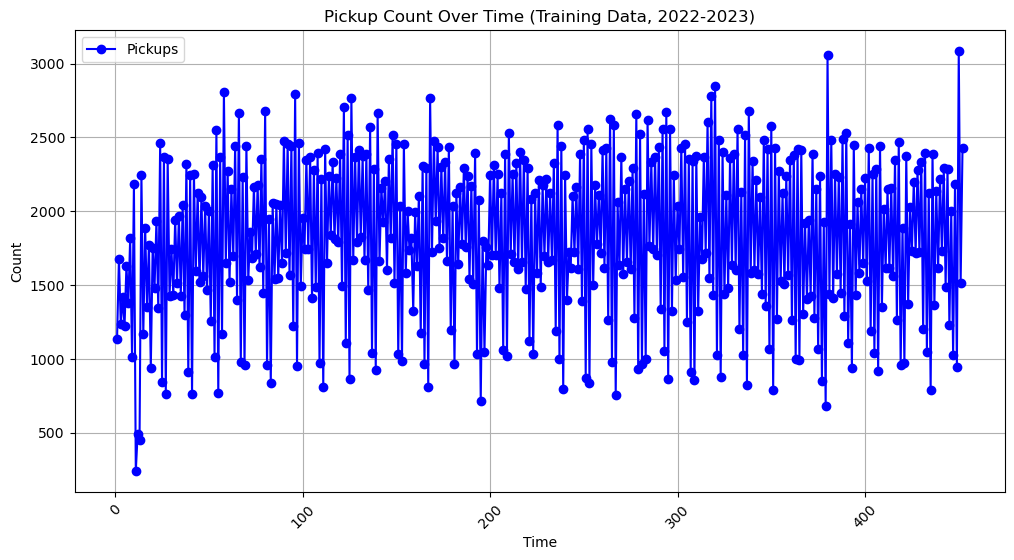

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, 2022-2023)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

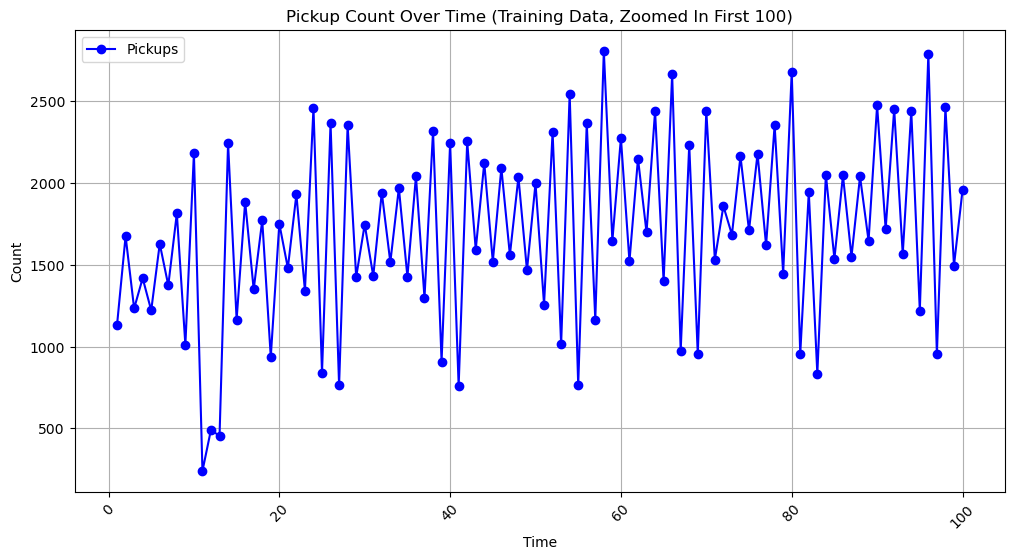

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, Zoomed In First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

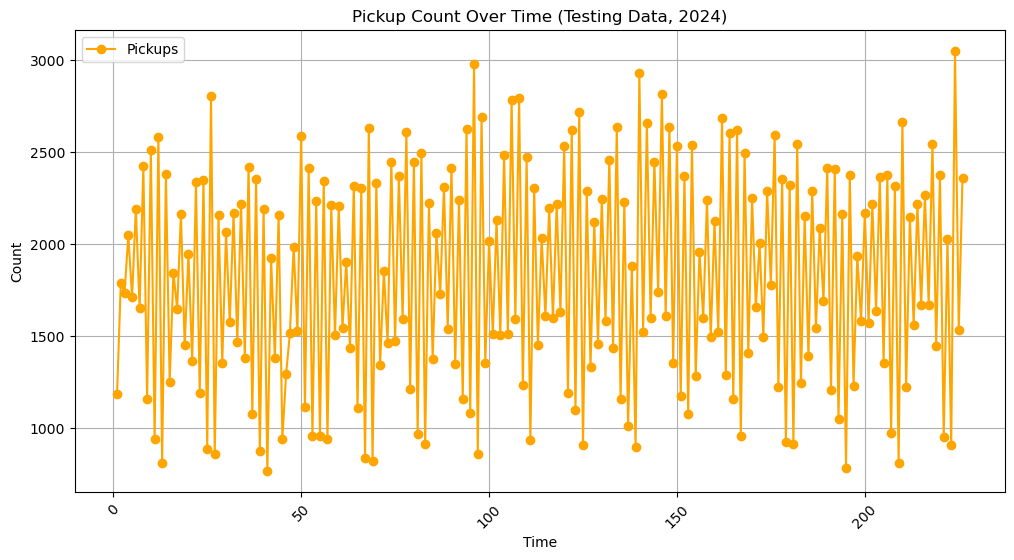

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Pickups', color='orange')
plt.title('Pickup Count Over Time (Testing Data, 2024)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

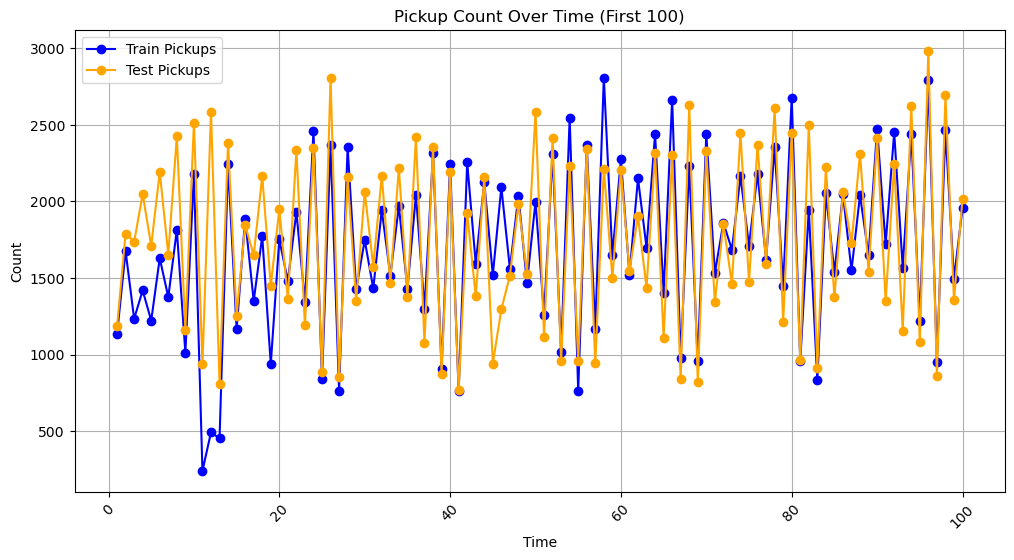

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Train Pickups', color='blue')
plt.plot(test['time_index'][:100], test['pickup_count'][:100], marker='o', label='Test Pickups', color='orange')
plt.title('Pickup Count Over Time (First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## Over the hour

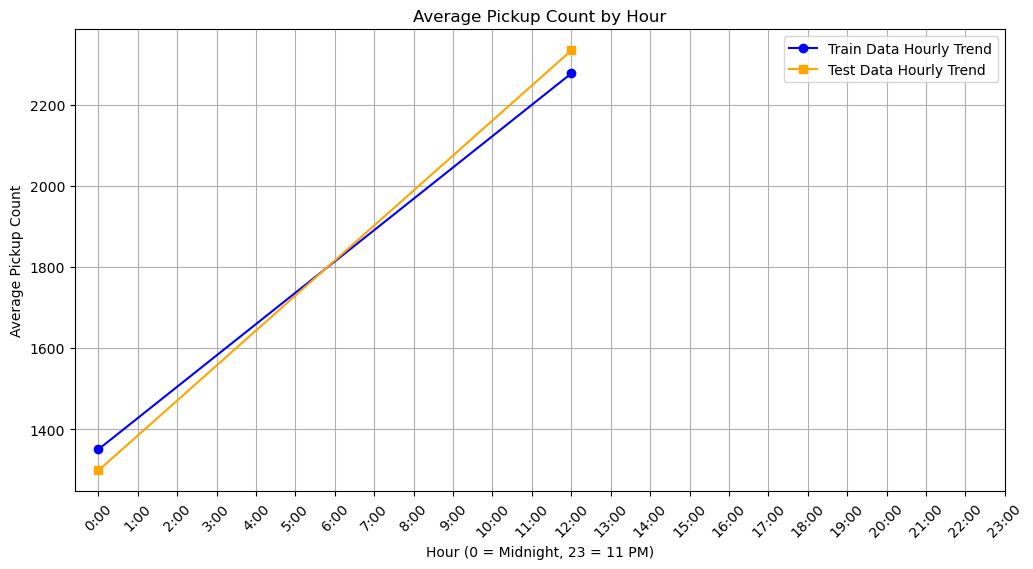

In [37]:
# Group by hour and calculate the mean pickup count for each hour
hourly_trend_train = train.groupby('hour')['pickup_count'].mean()
hourly_trend_test = test.groupby('hour')['pickup_count'].mean()

# Plot hourly trend
plt.figure(figsize=(12, 6))
plt.plot(
    hourly_trend_train.index,
    hourly_trend_train.values,
    marker='o',
    label='Train Data Hourly Trend',
    color='blue'
)
plt.plot(
    hourly_trend_test.index,
    hourly_trend_test.values,
    marker='s',
    label='Test Data Hourly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Hour')
plt.xlabel('Hour (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(0, 24),
    labels=[f'{h}:00' for h in range(0, 24)],  # Formats hour labels as '0:00', '1:00', etc.
    rotation=45
)
plt.grid()
plt.legend()
plt.show()

## Over each weekday

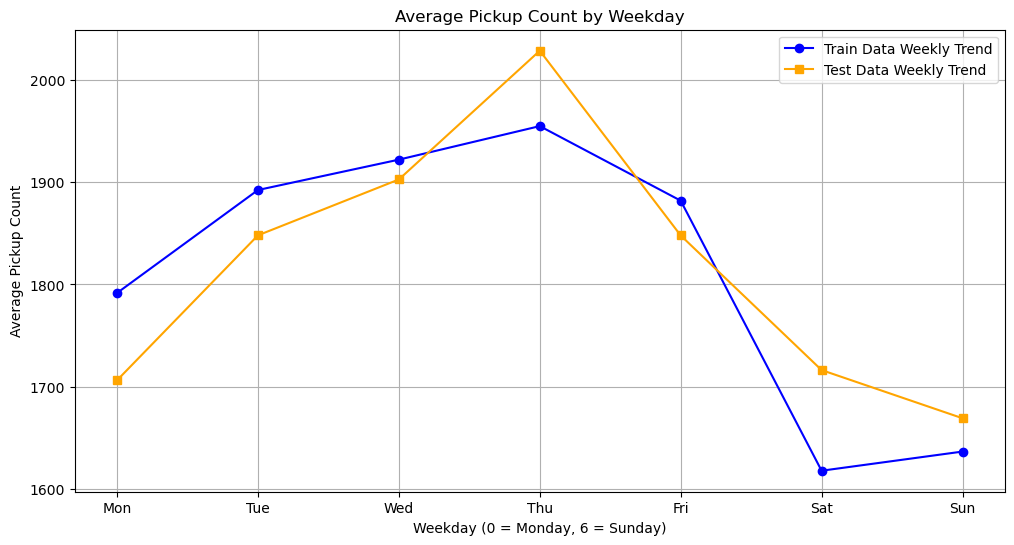

In [38]:
# Group by weekday and calculate the mean pickup count for each weekday
weekly_trend_train = train.groupby('weekday')['pickup_count'].mean()
weekly_trend_test = test.groupby('weekday')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Weekday')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=weekly_trend_train.index,
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.grid()
plt.legend()
plt.show()


## Over the weeks

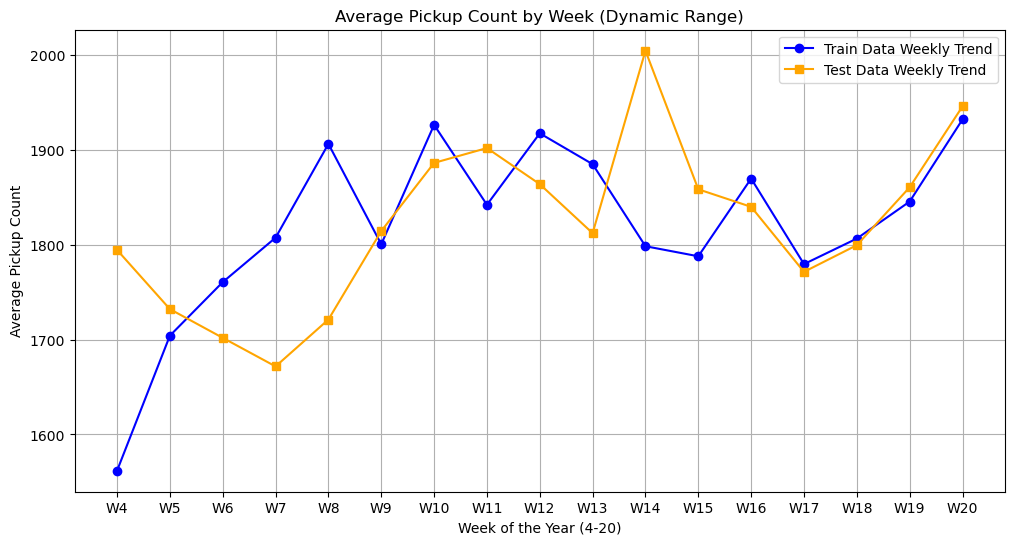

In [39]:
# Group by week of the year and calculate the mean pickup count for each week
train['pickup_time'] = pd.to_datetime(train['pickup_time'])
test['pickup_time'] = pd.to_datetime(test['pickup_time'])
train['week'] = train['pickup_time'].dt.isocalendar().week
test['week'] = test['pickup_time'].dt.isocalendar().week

# Determine the min and max week from both datasets
min_week = min(train['week'].min(), test['week'].min())
max_week = max(train['week'].max(), test['week'].max())

# Group by week for the range of weeks in the data
weekly_trend_train = train.groupby('week')['pickup_count'].mean()
weekly_trend_test = test.groupby('week')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Week (Dynamic Range)')
plt.xlabel(f'Week of the Year ({min_week}-{max_week})')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(min_week, max_week + 1, max(1, (max_week - min_week) // 10)),  # Adjust ticks dynamically
    labels=[f'W{k}' for k in range(min_week, max_week + 1, max(1, (max_week - min_week) // 10))]
)
plt.grid()
plt.legend()
plt.show()


## Over the month

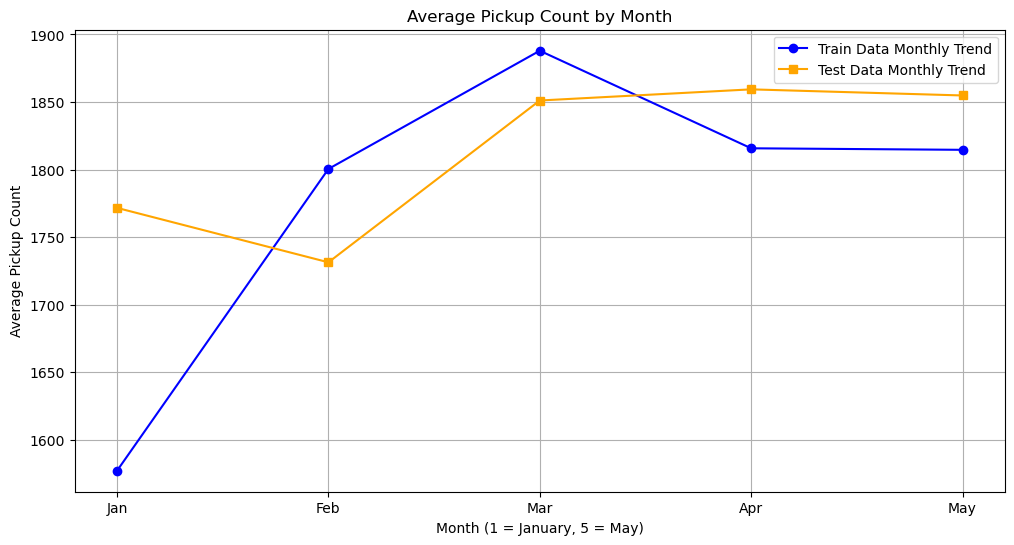

In [40]:
# Group by month and calculate the mean pickup count for each month
monthly_trend_train = train.groupby(train['pickup_time'].dt.month)['pickup_count'].mean()
monthly_trend_test = test.groupby(test['pickup_time'].dt.month)['pickup_count'].mean()

# Plot monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_trend_train.index,
    monthly_trend_train.values,
    marker='o',
    label='Train Data Monthly Trend',
    color='blue'
)
plt.plot(
    monthly_trend_test.index,
    monthly_trend_test.values,
    marker='s',
    label='Test Data Monthly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Month')
plt.xlabel('Month (1 = January, 5 = May)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(1, 6),
    labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May'
    ]
)
plt.grid()
plt.legend()
plt.show()


## Model Fitting - try GP

## All vars

In [41]:
# Features (X) - Including the new feature
## Let's try the hstack method
train['year'] = train['pickup_time'].dt.year  # Extract year from pickup_time
train_by_year = [group[['hour', 'weekday']].values for _, group in train.groupby('year')]
X_train = np.hstack(train_by_year)[:,0:2]  # Horizontally stack features by year

test['year'] = test['pickup_time'].dt.year  # Extract year from pickup_time
test_by_year = [group[['hour', 'weekday']].values for _, group in test.groupby('year')]
X_test = np.hstack(test_by_year)  # Horizontally stack features by year


# X_train
#X_train = train[['hour', 'weekday']].values
#X_test = test[['hour', 'weekday']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour']].values
#X_test = test[['hour']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
train_by_year = [group[['pickup_count']].values for _, group in train.groupby('year')]
y_train = np.hstack(train_by_year).mean(axis=1)  # Horizontally stack features by year

# Target (y)
mean_func = train['pickup_count'].mean()
#y_train = train['pickup_count'].values.astype(np.float64)  # Ensure float64 type for compatibility
y_test = test['pickup_count'].values.astype(np.float64)  # Also ensure float64 for consistenc

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [42]:
X_train

array([[-1.        , -1.47869908],
       [ 1.        , -1.47869908],
       [-1.        , -0.9813985 ],
       [ 1.        , -0.9813985 ],
       [-1.        , -0.48409791],
       [ 1.        , -0.48409791],
       [-1.        ,  0.01320267],
       [ 1.        ,  0.01320267],
       [-1.        ,  0.51050325],
       [ 1.        ,  0.51050325],
       [-1.        ,  1.00780384],
       [ 1.        ,  1.00780384],
       [-1.        ,  1.50510442],
       [ 1.        ,  1.50510442],
       [-1.        , -1.47869908],
       [ 1.        , -1.47869908],
       [-1.        , -0.9813985 ],
       [ 1.        , -0.9813985 ],
       [-1.        , -0.48409791],
       [ 1.        , -0.48409791],
       [-1.        ,  0.01320267],
       [ 1.        ,  0.01320267],
       [-1.        ,  0.51050325],
       [ 1.        ,  0.51050325],
       [-1.        ,  1.00780384],
       [ 1.        ,  1.00780384],
       [-1.        ,  1.50510442],
       [ 1.        ,  1.50510442],
       [-1.        ,

In [43]:
y_train

array([1311.5, 1927. , 1464.5, 1820. , 1440.5, 1874.5, 1520.5, 2071. ,
       1098. , 2381.5,  618.5, 1468.5,  624. , 2245. , 1282.5, 1805.5,
       1481.5, 1937. , 1329.5, 1957. , 1546. , 2159. , 1366.5, 2470.5,
        857. , 2462. ,  801. , 2404. , 1462.5, 1961.5, 1605. , 2025.5,
       1618. , 2193.5, 1522.5, 2234. , 1282. , 2472. ,  944. , 2415. ,
        757. , 2157. , 1613.5, 2245.5, 1546.5, 2122. , 1607. , 2121. ,
       1538. , 2146. , 1268.5, 2485. ,  971. , 2535. ,  865.5, 2241. ,
       1081.5, 2713.5, 1707.5, 2302.5, 1633. , 2259.5, 1701. , 2437. ,
       1370. , 2610.5, 1014. , 2451.5,  909.5, 2499.5, 1428.5, 2051. ,
       1610. , 2099. , 1726. , 2305.5, 1586. , 2406. , 1348. , 2515. ,
        932.5, 2144. ,  845.5, 2211.5, 1432. , 2003. , 1612. , 2204. ,
       1682.5, 2539. , 1631.5, 2617. , 1498.5, 2644.5, 1122.5, 2636.5,
        916.5, 2432. , 1467. , 2032. , 1610.5, 2354.5, 1692.5, 2378.5,
       1504.5, 2418. , 1342. , 2260.5,  997.5, 2370. ,  815.5, 2548.5,
      

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((226, 2), (226,), (226, 2), (226,))

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │            value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      0           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].lengthscales             │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 474913           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────

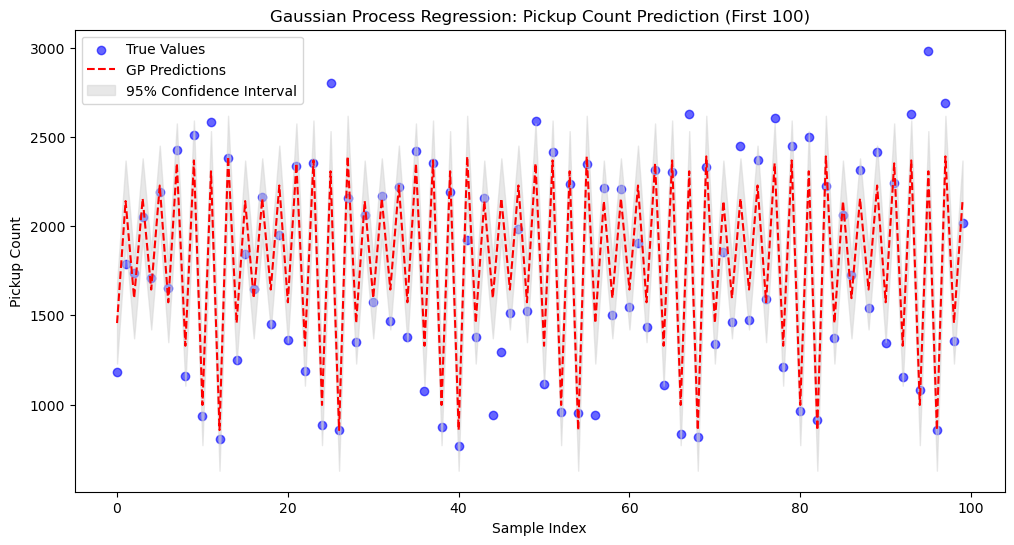

Sigma
114.76602895042448


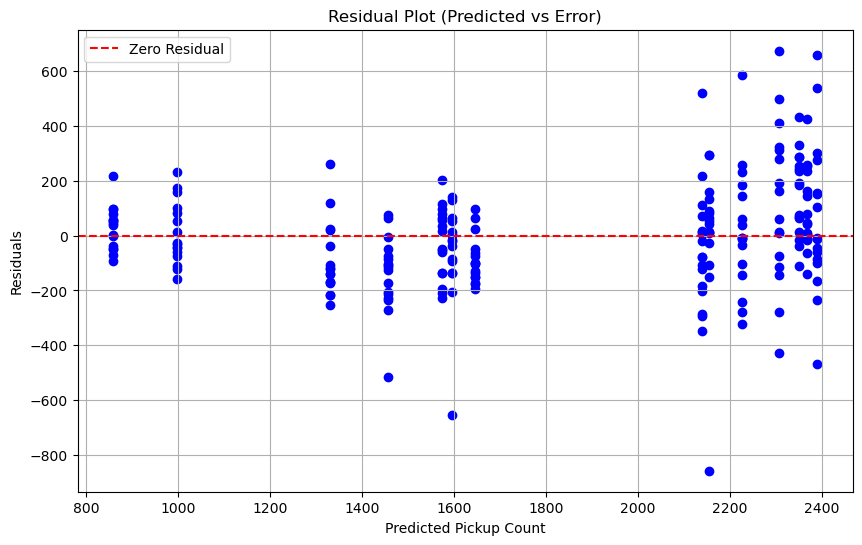

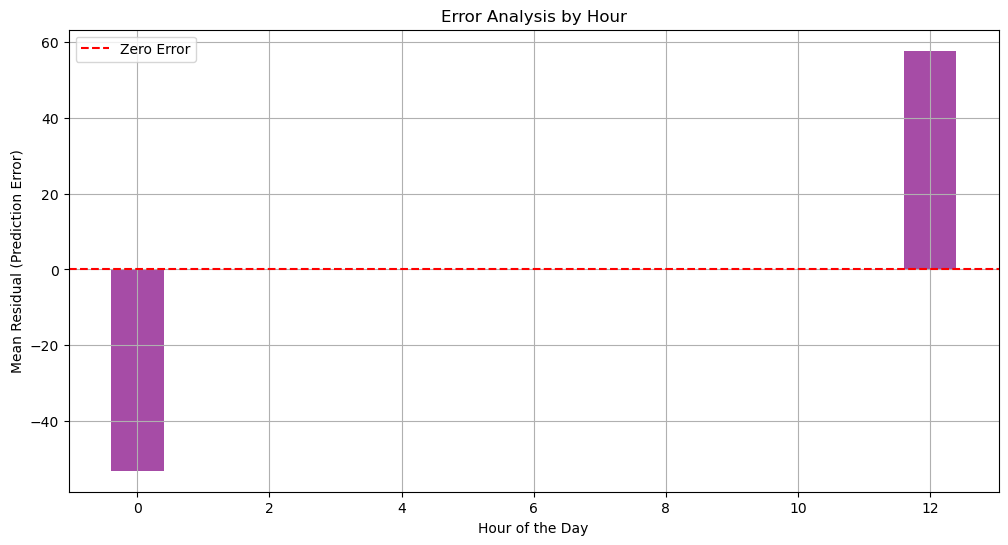

224.941416742832
114.76602895042448
Root Mean Squared Error: 199.080
MAPE: 0.084


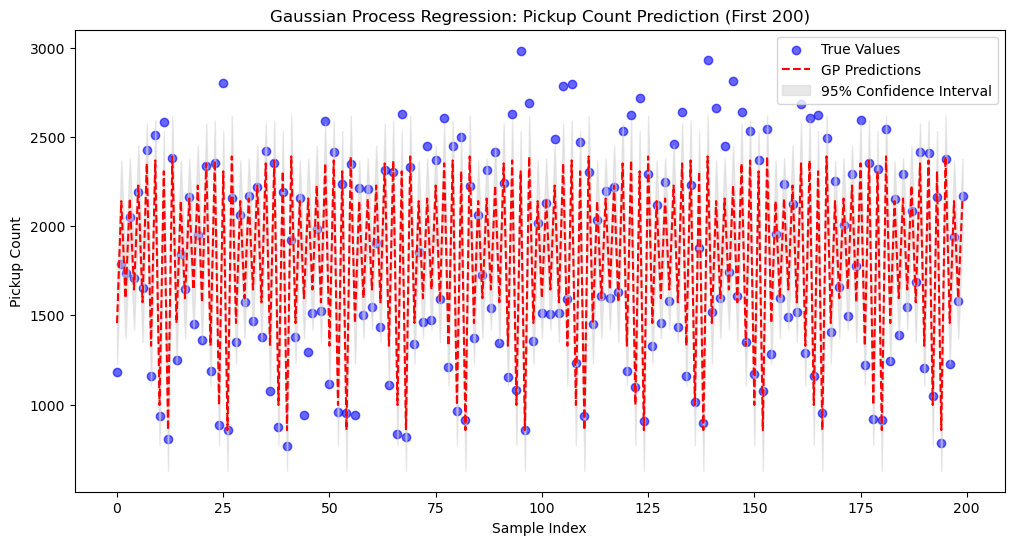

Sigma
114.76602895042448


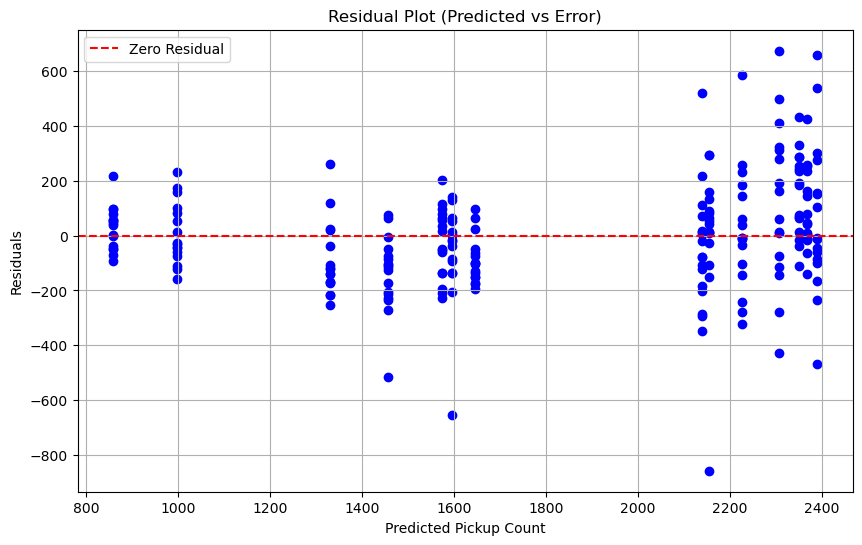

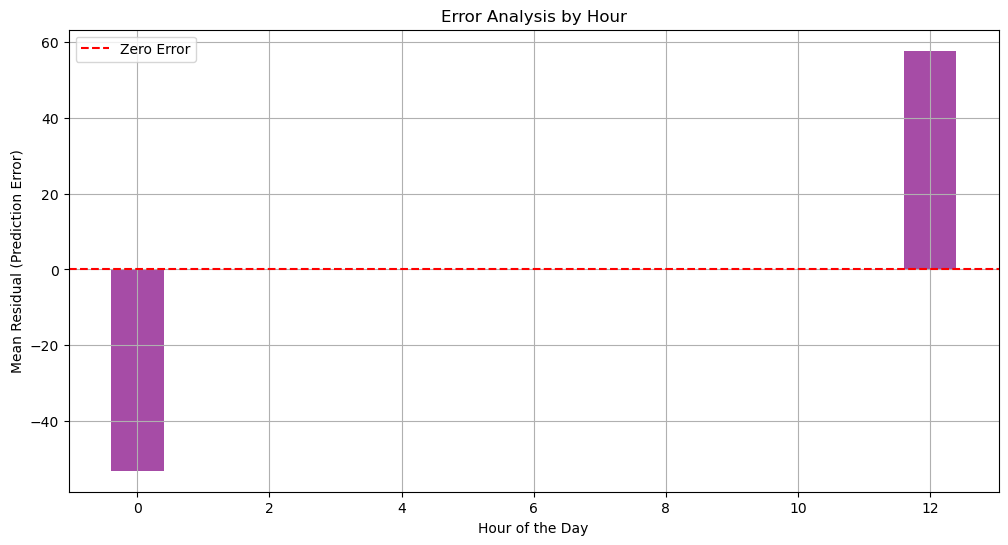

In [45]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
squared_exponential = gpflow.kernels.SquaredExponential()
sinusoidal = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=1)
white_noise = gpflow.kernels.White()
kernel = squared_exponential + sinusoidal + white_noise

mean_func = y_train.reshape(-1,1).mean()

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, (y_train.reshape(-1, 1) - mean_func)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │            value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 245728           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      0.000140909 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────

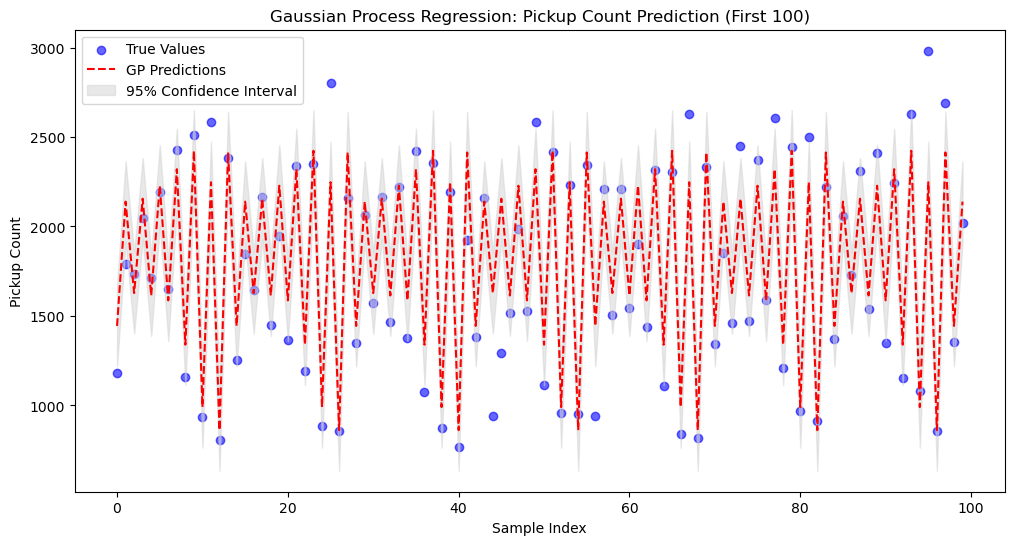

Sigma
115.51969035497825


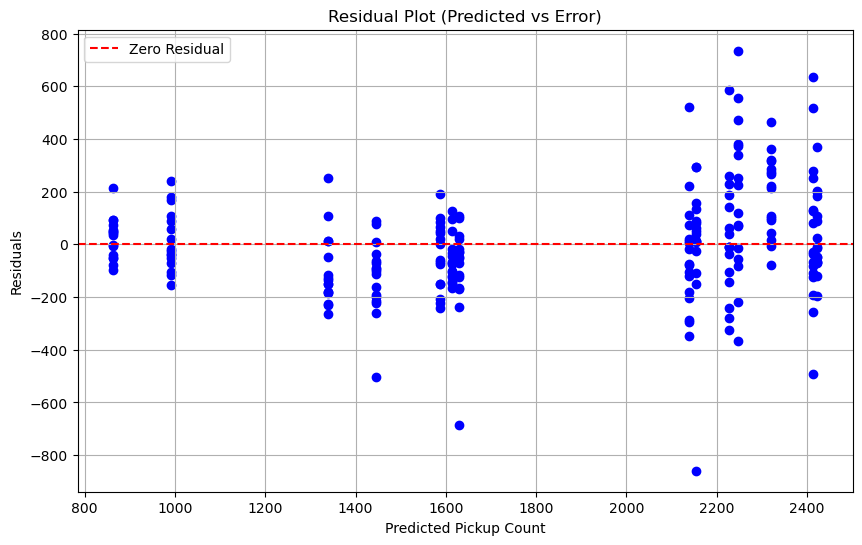

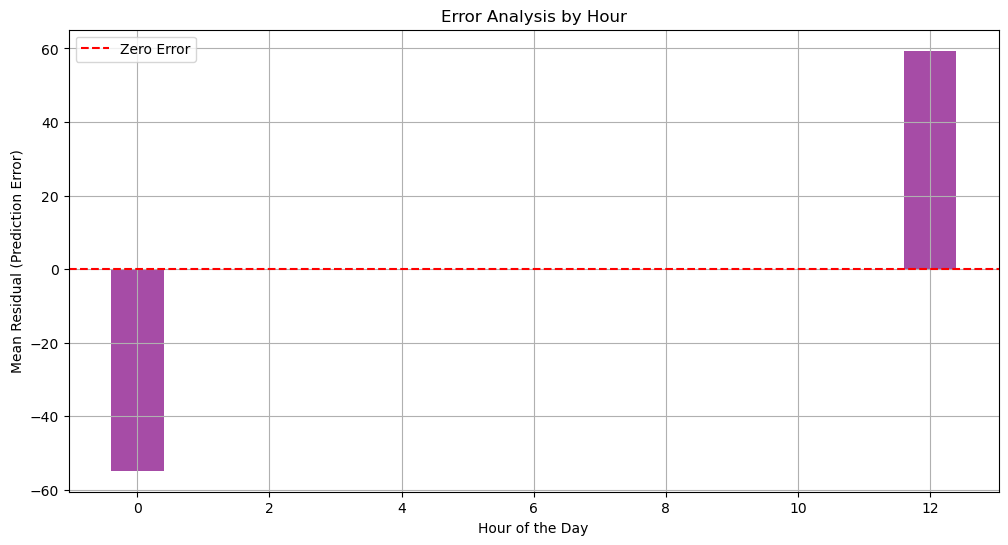

226.41859309575736
115.51969035497825
Root Mean Squared Error: 202.415
MAPE: 0.085


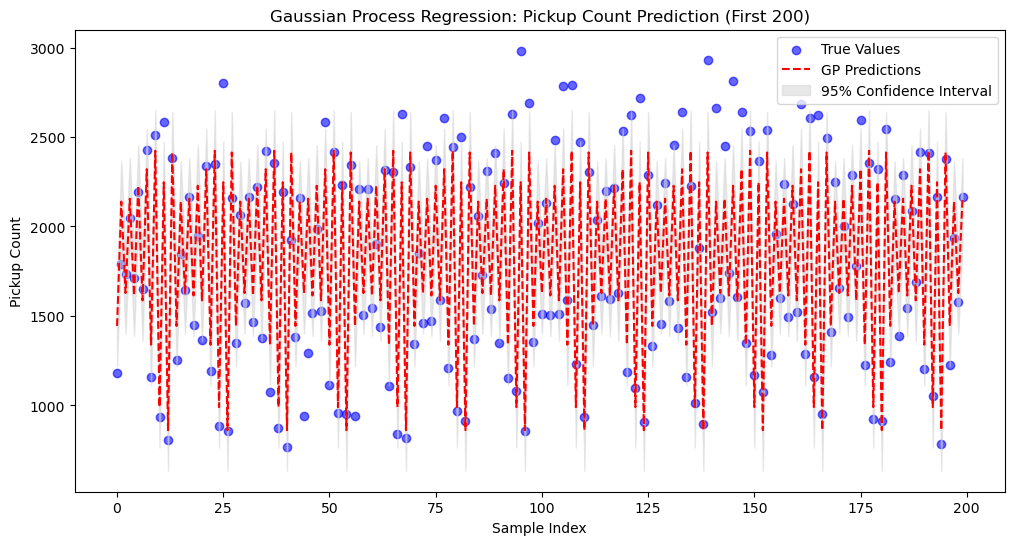

Sigma
115.51969035497825


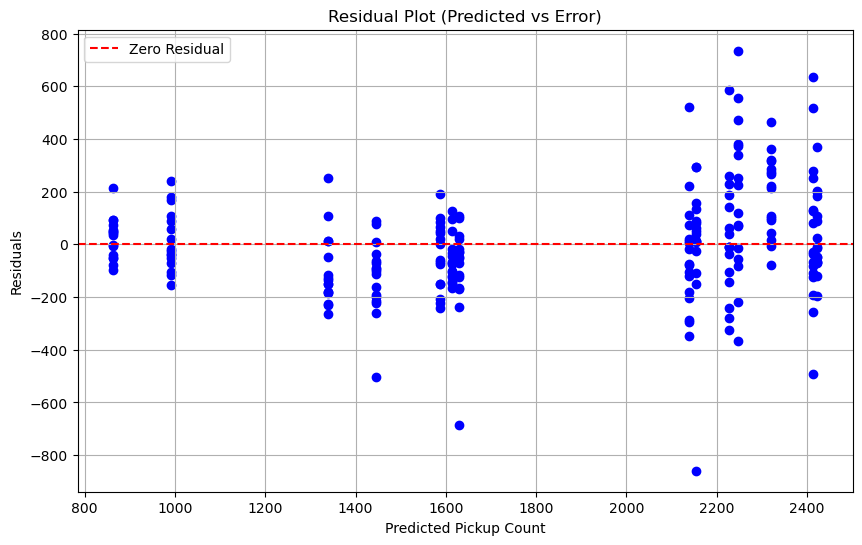

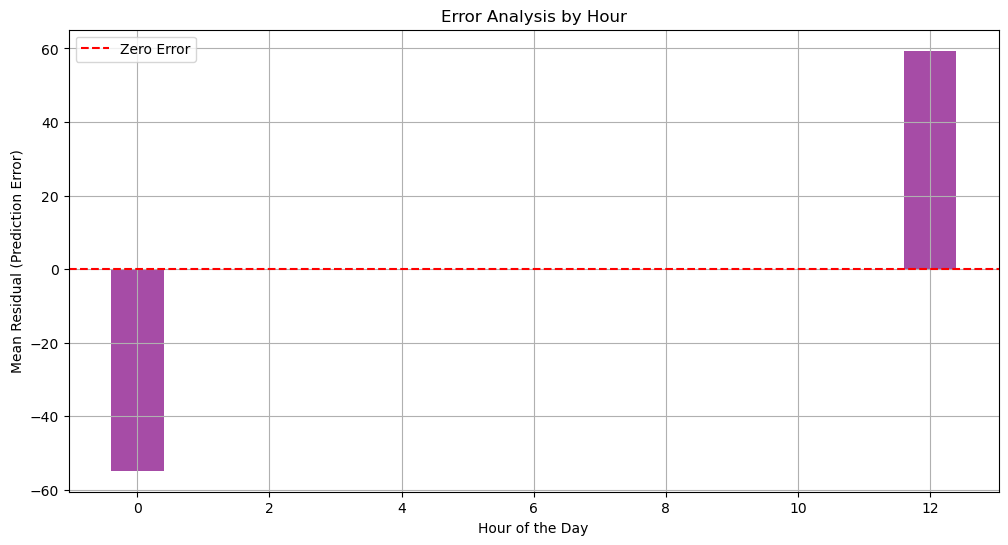

In [46]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
sinusoidal2 = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=1)
white_noise = gpflow.kernels.White()
kernel = sinusoidal2 + white_noise

mean_func = y_train.reshape(-1,1).mean()

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, (y_train.reshape(-1, 1) - mean_func)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


## Simpler

## FINAL

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │            value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 245728           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      0.000140909 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────

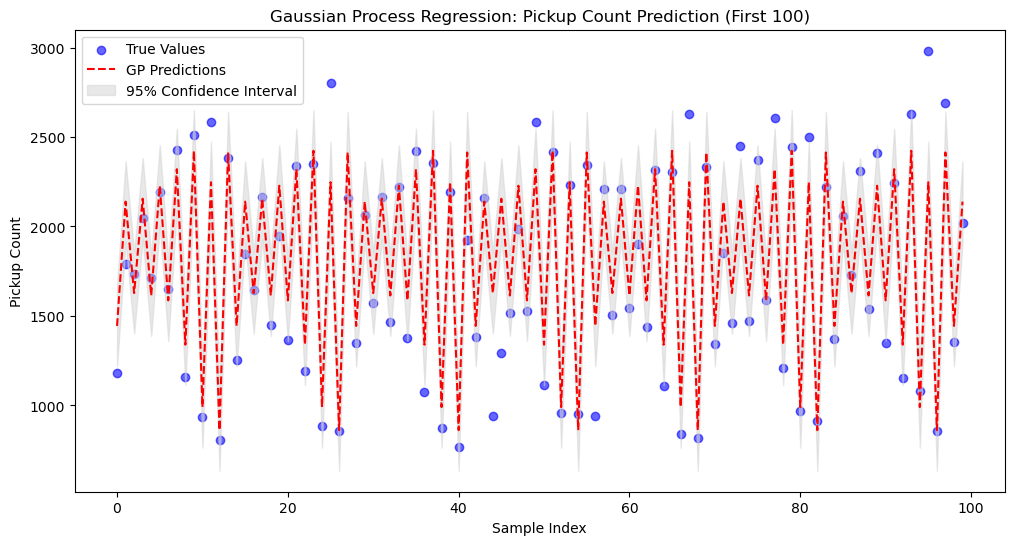

Sigma
115.51969035497825


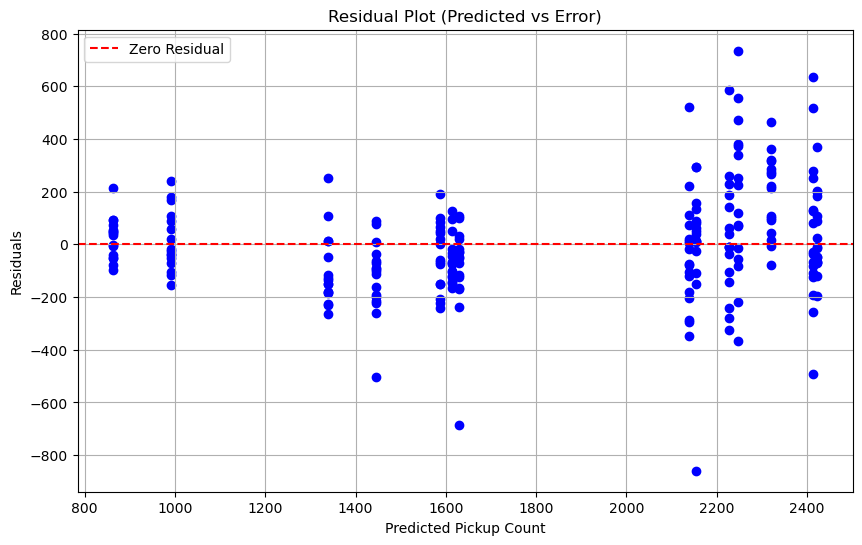

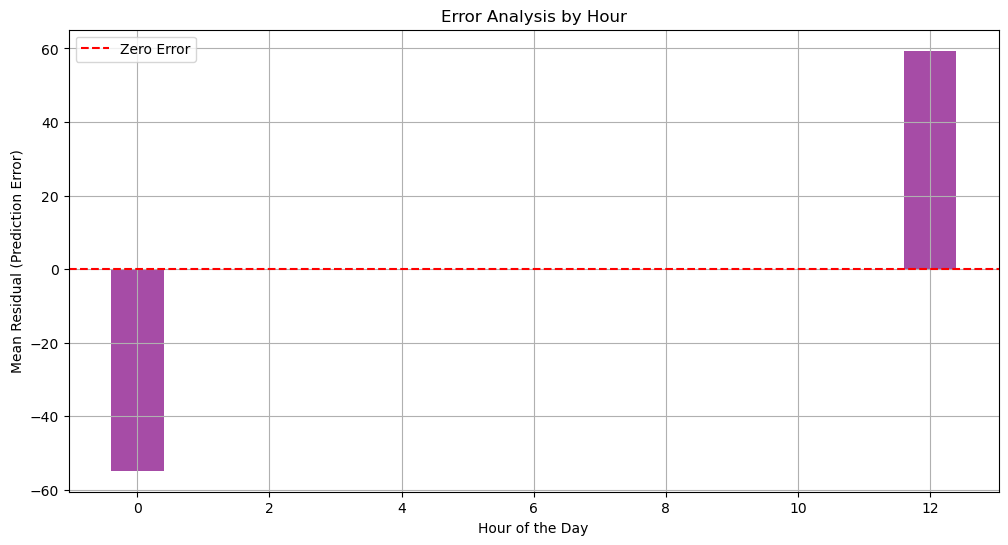

226.41859309575736
115.51969035497825
Root Mean Squared Error: 202.415
MAPE: 0.085


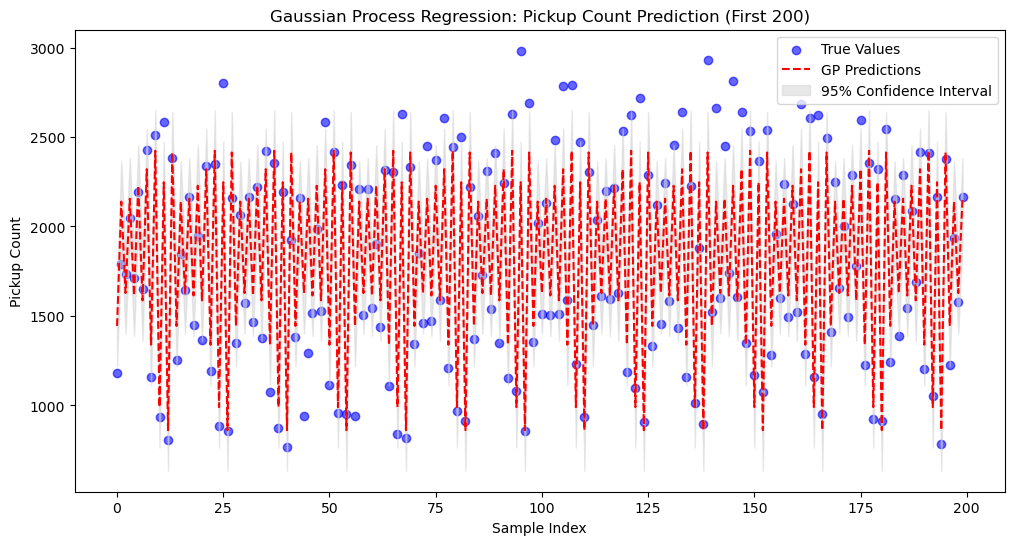

Sigma
115.51969035497825


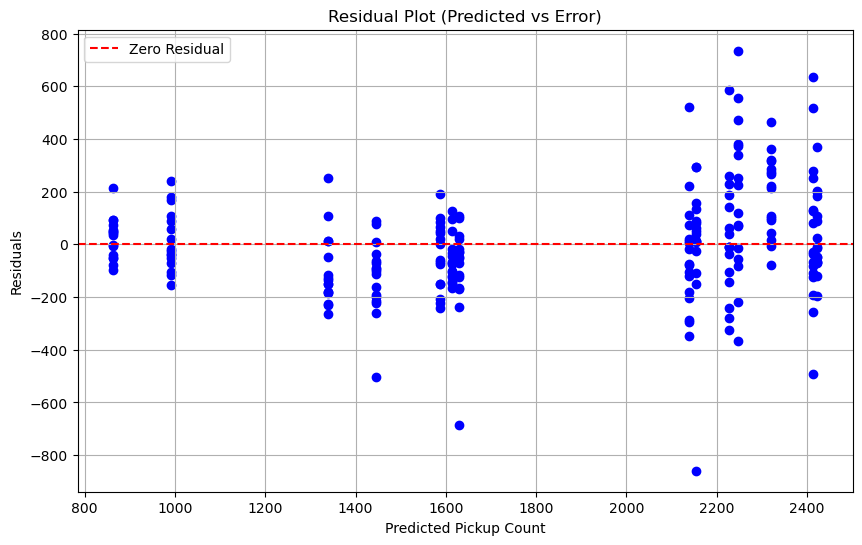

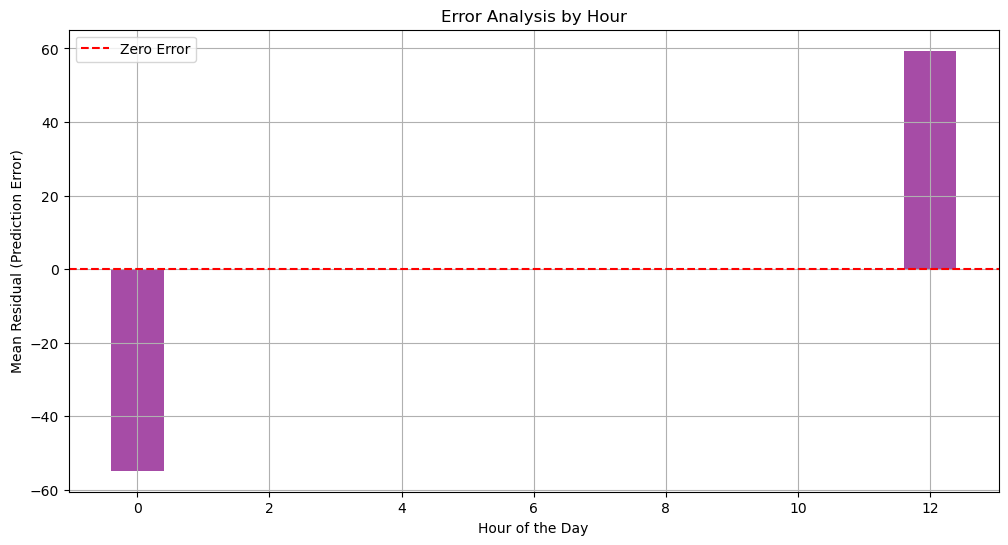

In [47]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
sinusoidal2 = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=1)
white_noise = gpflow.kernels.White()
kernel = sinusoidal2 + white_noise

mean_func = y_train.reshape(-1,1).mean()

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, (y_train.reshape(-1, 1) - mean_func)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       0 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  474913 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  141224 │
├───────

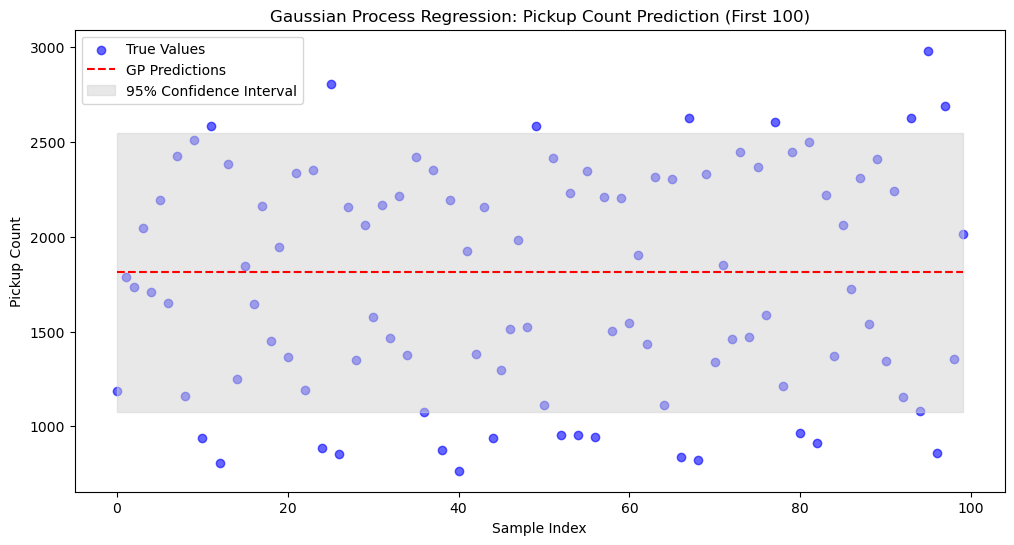

Sigma
375.797796700502


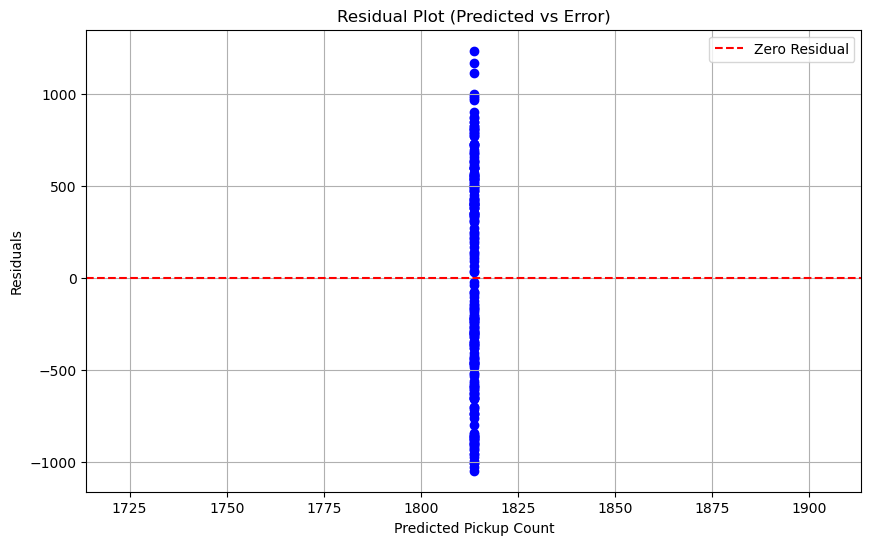

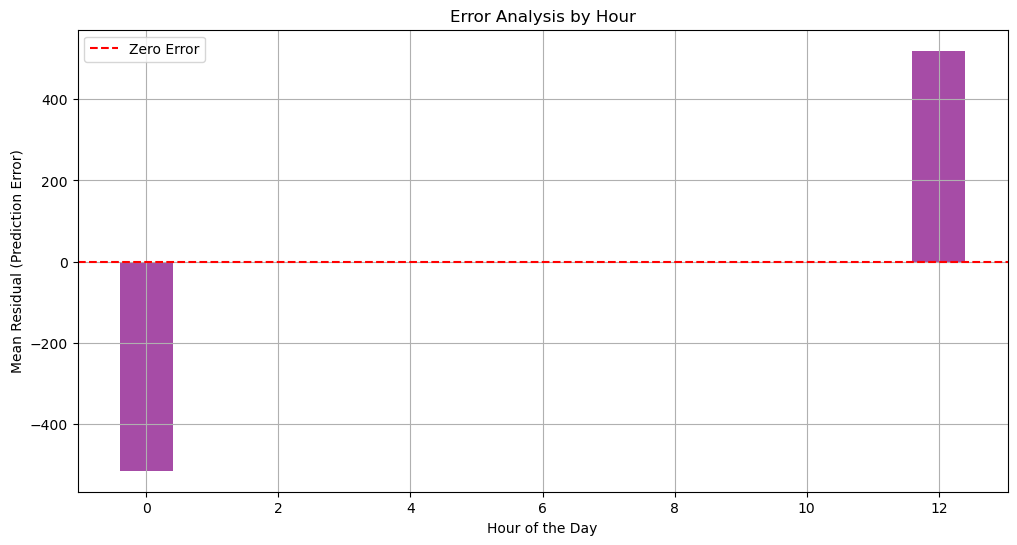

736.5636815329839
375.797796700502
Root Mean Squared Error: 586.317
MAPE: 0.345


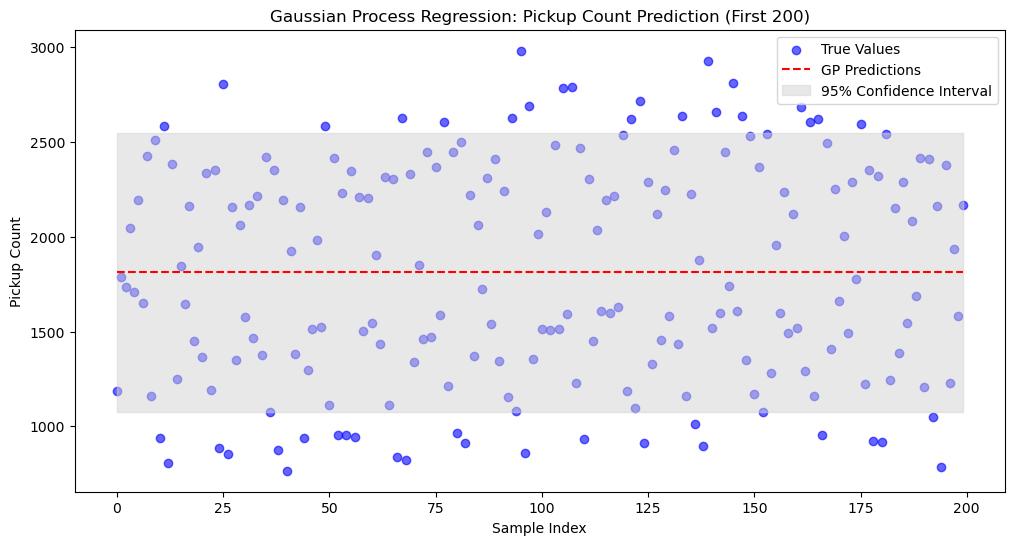

Sigma
375.797796700502


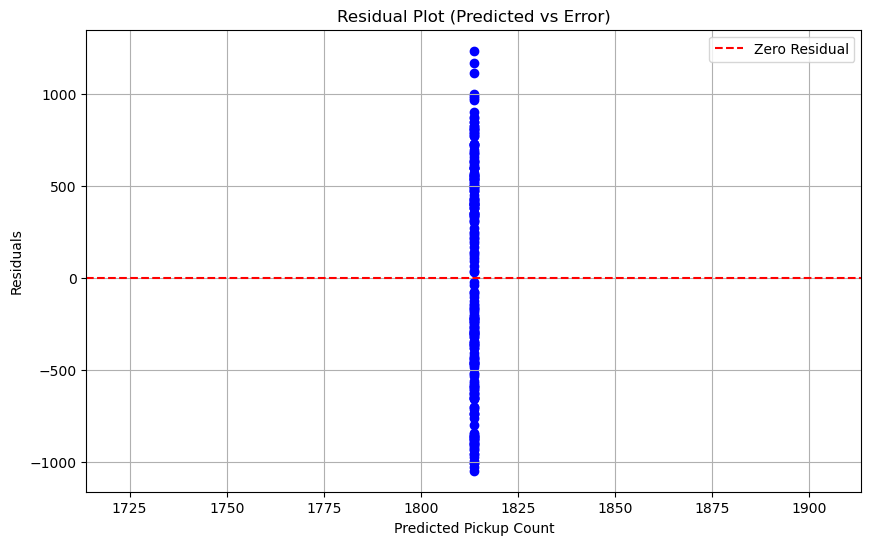

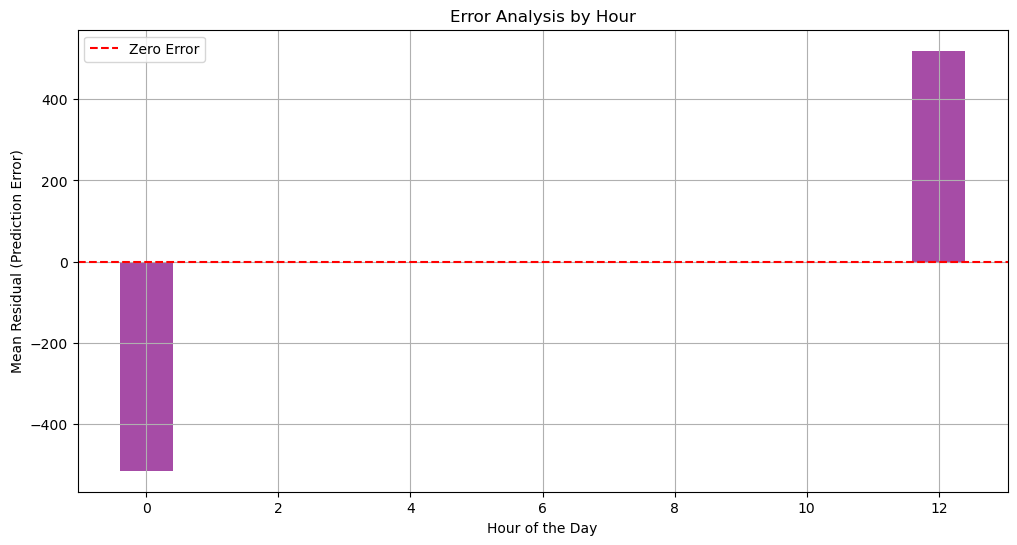

In [49]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
sinusoidal2 = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=6)
white_noise = gpflow.kernels.White()
kernel = squared_exponential + white_noise

mean_func = y_train.reshape(-1,1).mean()

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, (y_train.reshape(-1, 1) - mean_func)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()
